## Dependencies

In [1]:
import json, warnings, shutil, glob
from jigsaw_utility_scripts import *
from scripts_step_lr_schedulers import *
from transformers import TFXLMRobertaModel, XLMRobertaConfig
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


## TPU configuration

In [2]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load data

In [3]:
database_base_path = '/kaggle/input/jigsaw-data-split-roberta-192-ratio-2-clean-polish/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
valid_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv", 
                       usecols=['comment_text', 'toxic', 'lang'])

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print('Validation samples: %d' % len(valid_df))
display(valid_df.head())

base_data_path = 'fold_1/'
fold_n = 1
# Unzip files
!tar -xf /kaggle/input/jigsaw-data-split-roberta-192-ratio-2-clean-polish/fold_1.tar.gz

Train samples: 400830


,comment_text,toxic,length,word_count,token_count,toxic_int,fold_1,fold_2,fold_3,fold_4,fold_5
0,And you have something alien on your lips Chan...,0.000000,146,28,40,0,train,train,validation,train,train
1,no income tax for anyone that comes and works ...,0.166667,154,30,41,0,train,train,train,train,validation
2,"Rubbish, Brandon. Nothing stopped Comey of the...",0.833333,444,75,105,1,train,train,validation,train,train
3,poster I have sent the e-mail. -Garrett,0.000000,39,7,14,0,train,train,validation,train,train
4,== ECB exposure == I responded to a comment of...,0.000000,66,13,23,0,train,train,validation,train,train


Validation samples: 8000


,comment_text,lang,toxic
0,Este usuario ni siquiera llega al rango de ...,es,0
1,Il testo di questa voce pare esser scopiazzato...,it,0
2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


# Model parameters

In [4]:
base_path = '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/'

config = {
  "MAX_LEN": 192,
  "BATCH_SIZE": 128,
  "EPOCHS": 3,
  "LEARNING_RATE": 1e-5, 
  "ES_PATIENCE": None,
  "base_model_path": base_path + 'tf-xlm-roberta-large-tf_model.h5',
  "config_path": base_path + 'xlm-roberta-large-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'MAX_LEN': 192,
 'BATCH_SIZE': 128,
 'EPOCHS': 3,
 'LEARNING_RATE': 1e-05,
 'ES_PATIENCE': None,
 'base_model_path': '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/tf-xlm-roberta-large-tf_model.h5',
 'config_path': '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/xlm-roberta-large-config.json'}

## Learning rate schedule

Learning rate schedule: 0 to 9.63e-06 to 1.12e-07


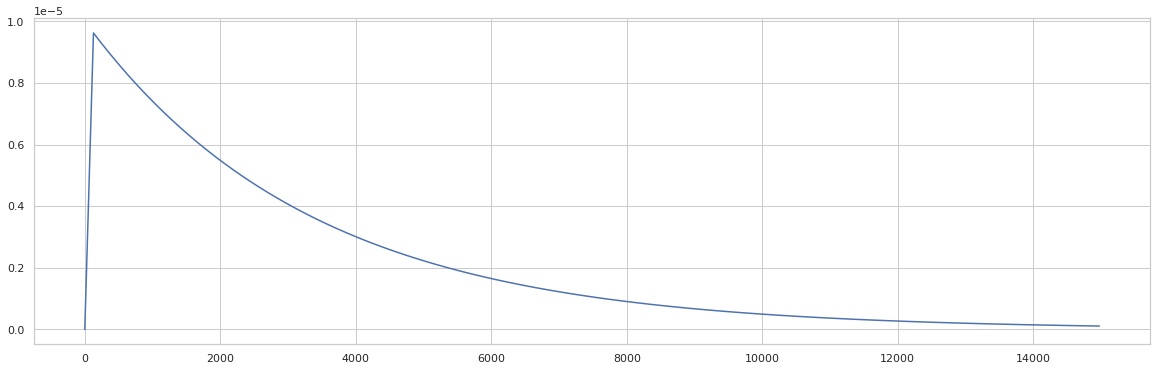

In [5]:
lr_start = 0
lr_max = config['LEARNING_RATE']
step_size = (len(k_fold[k_fold[f'fold_{fold_n}'] == 'train']) * 2 )// config['BATCH_SIZE'] # with tail
total_steps = config['EPOCHS'] * step_size
warmup_steps = 1
decay = .9997

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps=warmup_steps, 
                                      lr_start=lr_start, lr_max=lr_max, decay=decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [6]:
module_config = XLMRobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFXLMRobertaModel.from_pretrained(config['base_model_path'], config=module_config)
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    cls_token = last_hidden_state[:, 0, :]
    
    output = layers.Dense(1, activation='sigmoid', name='output')(cls_token)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    
    return model

# Train

In [7]:
# Training
def custom_fit(model, metrics_dict, train_step_fn, valid_step_fn, valid_2_step_fn, train, validation, validation_2, 
               train_step_size, validation_step_size, validation_2_step_size, batch_size, epochs, patience=None, 
               model_path='model.h5', save_last=False, checkpoint_freq=None):
        
    # ==================== Setup training loop ====================
    step = 0
    epoch = 0
    epoch_steps = 0
    epoch_start_time = time.time()
    patience_cnt = 0
    best_val = float("inf")
    
    history = {}
    for metric in metrics_dict.keys():
        history[metric] = []

    print(f'Train for {train_step_size} steps, validate for {validation_step_size} steps, validate_2 for {validation_2_step_size} steps')
    # ==================== Train model ====================
    while True:
        train_step_fn(train)
        epoch_steps += train_step_size
        step += train_step_size

        # validation run at the end of each epoch
        if (step // train_step_size) > epoch:
            # validation run
            valid_epoch_steps = 0
            valid_step_fn(validation)
            valid_epoch_steps += validation_step_size
            # validation_2 run
            valid_2_epoch_steps = 0
            valid_2_step_fn(validation_2)
            valid_2_epoch_steps += validation_2_step_size
            
            # compute metrics
            for metric in metrics_dict.keys():
                if 'loss' in metric:
                    if 'val_' in metric: # loss from validation
                        history[metric].append(metrics_dict[metric].result().numpy() / (batch_size * valid_epoch_steps))
                    elif 'val_2_' in metric: # loss from validation_2
                        history[metric].append(metrics_dict[metric].result().numpy() / (batch_size * valid_2_epoch_steps))
                    else: # loss from training
                        history[metric].append(metrics_dict[metric].result().numpy() / (batch_size * epoch_steps))
                else: # any other metric
                    history[metric].append(metrics_dict[metric].result().numpy())

            # report metrics
            epoch_time = time.time() - epoch_start_time
            print('\nEPOCH {:d}/{:d}'.format(epoch+1, epochs))
            report = f"time: {epoch_time:0.1f}s"
            for metric in metrics_dict.keys():
                report += f" {metric}: {history[metric][-1]:0.4f}"
            print(report)

            # set up next epoch
            epoch = step // train_step_size
            epoch_steps = 0
            epoch_start_time = time.time()
            for metric in metrics_dict.values():
                metric.reset_states()
                
            # Model checkpoint
            if checkpoint_freq is not None:
                if epoch % checkpoint_freq == 0:
                    model_path_chk = 'ep_%d_%d' % (epoch, model_path)
                    model.save_weights(model_path_chk)
                    print('Checkpointing model weights at "%s"' % model_path_chk)

            if epoch <= epochs:
                if patience is not None:
                    # Early stopping monitor
                    if history['val_loss'][-1] <= best_val:
                        best_val = history['val_loss'][-1]
                        model.save_weights(model_path)
                        print('Saved model weights at "%s"' % model_path)
                    else:
                        patience_cnt += 1
                    if patience_cnt >= patience:
                        print('Epoch %05d: early stopping' % epoch)
                        if epoch < epochs:
                            return history
            if epoch >= epochs:
                if save_last:
                    model_path_last = 'last_' + model_path
                    model.save_weights(model_path_last)
                    print('Training finished saved model weights at "%s"' % model_path_last)
                else:
                    print('Training finished')
                    
                return history

In [8]:
# Load data
x_train = np.load(base_data_path + 'x_train.npy')
y_train = np.load(base_data_path + 'y_train_int.npy').reshape(x_train.shape[1], 1).astype(np.float32)
x_valid = np.load(base_data_path + 'x_valid.npy')
y_valid = np.load(base_data_path + 'y_valid_int.npy').reshape(x_valid.shape[1], 1).astype(np.float32)
x_valid_ml = np.load(database_base_path + 'x_valid.npy')
y_valid_ml = np.load(database_base_path + 'y_valid.npy').reshape(x_valid_ml.shape[1], 1).astype(np.float32)

#################### ADD TAIL ####################
x_train_tail = np.load(base_data_path + 'x_train_tail.npy')
y_train_tail = np.load(base_data_path + 'y_train_int_tail.npy').reshape(x_train_tail.shape[1], 1).astype(np.float32)
x_train = np.hstack([x_train, x_train_tail])
y_train = np.vstack([y_train, y_train_tail])

step_size = x_train.shape[1] // config['BATCH_SIZE']
valid_step_size = x_valid_ml.shape[1] // config['BATCH_SIZE']
valid_2_step_size = x_valid.shape[1] // config['BATCH_SIZE']

# Build TF datasets
train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid_ml, y_valid_ml, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
valid_2_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
train_data_iter = iter(train_dist_ds)
valid_data_iter = iter(valid_dist_ds)
valid_2_data_iter = iter(valid_dist_ds)

# Step functions
@tf.function
def train_step(data_iter):
    def train_step_fn(x, y):
        with tf.GradientTape() as tape:
            probabilities = model(x, training=True)
            loss = loss_fn(y, probabilities)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_auc.update_state(y, probabilities)
        train_loss.update_state(loss)
    for _ in tf.range(step_size):
        strategy.experimental_run_v2(train_step_fn, next(data_iter))

@tf.function
def valid_step(data_iter):
    def valid_step_fn(x, y):
        probabilities = model(x, training=False)
        loss = loss_fn(y, probabilities)
        valid_auc.update_state(y, probabilities)
        valid_loss.update_state(loss)
    for _ in tf.range(valid_step_size):
        strategy.experimental_run_v2(valid_step_fn, next(data_iter))

@tf.function
def valid_2_step(data_iter):
    def valid_step_fn(x, y):
        probabilities = model(x, training=False)
        loss = loss_fn(y, probabilities)
        valid_2_auc.update_state(y, probabilities)
        valid_2_loss.update_state(loss)
    for _ in tf.range(valid_2_step_size):
        strategy.experimental_run_v2(valid_step_fn, next(data_iter))

# Train model
with strategy.scope():
    model = model_fn(config['MAX_LEN'])
    
    lr = lambda: exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                  warmup_steps=warmup_steps, lr_start=lr_start, 
                                                  lr_max=lr_max, decay=decay)
    
    optimizer = optimizers.Adam(learning_rate=lr)
    loss_fn = losses.binary_crossentropy
    train_auc = metrics.AUC()
    valid_auc = metrics.AUC()
    valid_2_auc = metrics.AUC()
    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()
    valid_2_loss = metrics.Sum()

metrics_dict = {'loss': train_loss, 'auc': train_auc, 
                'val_loss': valid_loss, 'val_auc': valid_auc, 
                'val_2_loss': valid_2_loss, 'val_2_auc': valid_2_auc}

history = custom_fit(model, metrics_dict, train_step, valid_step, valid_2_step, train_data_iter, 
                     valid_data_iter, valid_2_data_iter, step_size, valid_step_size, valid_2_step_size, 
                     config['BATCH_SIZE'], config['EPOCHS'], config['ES_PATIENCE'], save_last=False)
# model.save_weights('model.h5')

# Make predictions
# x_train = np.load(base_data_path + 'x_train.npy')
# x_valid = np.load(base_data_path + 'x_valid.npy')
x_valid_ml_eval = np.load(database_base_path + 'x_valid.npy')

# train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE'], AUTO))
# valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE'], AUTO))
valid_ml_preds = model.predict(get_test_dataset(x_valid_ml_eval, config['BATCH_SIZE'], AUTO))

# k_fold.loc[k_fold[f'fold_{fold_n}'] == 'train', f'pred_{fold_n}'] = np.round(train_preds)
# k_fold.loc[k_fold[f'fold_{fold_n}'] == 'validation', f'pred_{fold_n}'] = np.round(valid_preds)
valid_df[f'pred_{fold_n}'] = valid_ml_preds


# Fine-tune on validation set
#################### ADD TAIL ####################
x_valid_ml_tail = np.hstack([x_valid_ml, np.load(database_base_path + 'x_valid_tail.npy')])
y_valid_ml_tail = np.vstack([y_valid_ml, y_valid_ml])

valid_step_size_tail = x_valid_ml_tail.shape[1] // config['BATCH_SIZE']

# Build TF datasets
train_ml_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_valid_ml_tail, y_valid_ml_tail, 
                                                                                 config['BATCH_SIZE'], AUTO, seed=SEED))
train_ml_data_iter = iter(train_ml_dist_ds)

history_ml = custom_fit(model, metrics_dict, train_step, valid_step, valid_2_step, train_data_iter, 
                        valid_data_iter, valid_2_data_iter, step_size, valid_step_size, valid_2_step_size, 
                        config['BATCH_SIZE'], 1, config['ES_PATIENCE'], save_last=False)

# Join history
for key in history_ml.keys():
    history[key] += history_ml[key]
    
model.save_weights('model.h5')

# Make predictions
valid_ml_preds = model.predict(get_test_dataset(x_valid_ml_eval, config['BATCH_SIZE'], AUTO))
valid_df[f'pred_ml_{fold_n}'] = valid_ml_preds

### Delete data dir
shutil.rmtree(base_data_path)

Train for 5010 steps, validate for 62 steps, validate_2 for 626 steps

EPOCH 1/3
time: 1529.1s loss: 0.2052 auc: 0.9709 val_loss: 0.2818 val_auc: 0.9237 val_2_loss: 2.8718 val_2_auc: 0.9218

EPOCH 2/3
time: 1373.4s loss: 0.1620 auc: 0.9816 val_loss: 0.2902 val_auc: 0.9172 val_2_loss: 2.9119 val_2_auc: 0.9191

EPOCH 3/3
time: 1373.4s loss: 0.1518 auc: 0.9838 val_loss: 0.3008 val_auc: 0.9180 val_2_loss: 3.0138 val_2_auc: 0.9166
Training finished
Train for 5010 steps, validate for 62 steps, validate_2 for 626 steps

EPOCH 1/1
time: 1373.3s loss: 0.1493 auc: 0.9843 val_loss: 0.2928 val_auc: 0.9170 val_2_loss: 3.0268 val_2_auc: 0.9159
Training finished


## Model loss graph

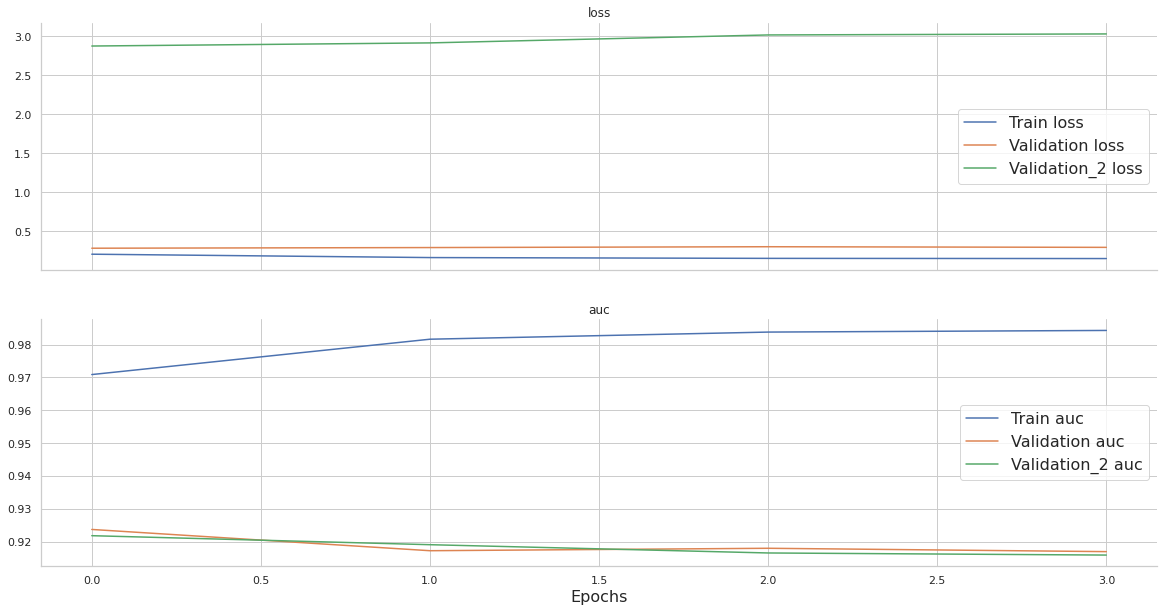

In [9]:
def plot_metrics(history):
    metric_list = list(history.keys())
    size = len(metric_list)//3
    fig, axes = plt.subplots(size, 1, sharex='col', figsize=(20, size * 5))
    axes = axes.flatten()
    
    for index in range(len(metric_list)//3):
        metric_name = metric_list[index]
        val_metric_name = metric_list[index+(size*1)]
        val_2_metric_name = metric_list[index+(size*2)]
        axes[index].plot(history[metric_name], label='Train %s' % metric_name)
        axes[index].plot(history[val_metric_name], label='Validation %s' % metric_name)
        axes[index].plot(history[val_2_metric_name], label='Validation_2 %s' % metric_name)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric_name)

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

plot_metrics(history)

# Model evaluation

In [10]:
# display(evaluate_model_single_fold(k_fold, fold_n, label_col='toxic_int').style.applymap(color_map))

# Confusion matrix

In [11]:
# train_set = k_fold[k_fold[f'fold_{fold_n}'] == 'train']
# validation_set = k_fold[k_fold[f'fold_{fold_n}'] == 'validation'] 
# plot_confusion_matrix(train_set['toxic_int'], train_set[f'pred_{fold_n}'], 
#                       validation_set['toxic_int'], validation_set[f'pred_{fold_n}'])

# Model evaluation by language

In [12]:
display(evaluate_model_single_fold_lang(valid_df, fold_n).style.applymap(color_map))
# ML fine-tunned preds
display(evaluate_model_single_fold_lang(valid_df, fold_n, pred_col='pred_ml').style.applymap(color_map))

,Mean,Fold_1
Lang / ROC AUC,,
Overall,0.924234,0.924234
es,0.906092,0.906092
it,0.891039,0.891039
tr,0.979134,0.979134


,Mean,Fold_1
Lang / ROC AUC,,
Overall,0.924277,0.924277
es,0.906290,0.906290
it,0.891476,0.891476
tr,0.978624,0.978624


# Visualize predictions

In [13]:
pd.set_option('max_colwidth', 120)
print('English validation set')
display(k_fold[['comment_text', 'toxic'] + [c for c in k_fold.columns if c.startswith('pred')]].head(10))

print('Multilingual validation set')
display(valid_df[['comment_text', 'toxic'] + [c for c in valid_df.columns if c.startswith('pred')]].head(10))

English validation set


,comment_text,toxic
0,And you have something alien on your lips Chance. Geez dude give it up. Better yet why don't you ask the Krotch brot...,0.000000
1,no income tax for anyone that comes and works and leaves. no income tax for retirees that come and work and leave. n...,0.166667
2,"Rubbish, Brandon. Nothing stopped Comey of the FBI of dumping the phony story about a new investigation in Hillary's...",0.833333
3,poster I have sent the e-mail. -Garrett,0.000000
4,== ECB exposure == I responded to a comment of yours here. Cheers.,0.000000
5,"You said, Let's keep abortion safe. Did you mean safe for the mom, or safe for the baby? God forgives women (and men...",0.200000
6,I was responding to Gary (and others) and the letter writer. I believe Christians would be slow to act in this situa...,0.000000
7,Now you disagree with your own comment?,0.000000
8,Amarista definitely needs to go away. If for no other reason than the best poster on this site Northsider will see h...,0.000000
9,"Corspefucking Art I used their offical website as help to gte al information right. Therefore, some sentences were l...",1.000000


Multilingual validation set


,comment_text,toxic,pred_1,pred_ml_1
0,Este usuario ni siquiera llega al rango de hereje . Por lo tanto debería ser quemado en la barbacoa para purifi...,0,8.355948e-01,8.341311e-01
1,"Il testo di questa voce pare esser scopiazzato direttamente da qui. Immagino possano esserci problemi di copyright, ...",0,7.355213e-05,6.151199e-05
2,"Vale. Sólo expongo mi pasado. Todo tiempo pasado fue mejor, ni mucho menos, yo no quisiera retroceder 31 años a nive...",1,9.740804e-01,9.733392e-01
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var.Önerim siy...,0,2.682209e-07,4.768372e-07
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın. Ben de uzak gelecek...,0,5.951524e-05,2.905726e-05
5,"güzel, zaten kaynaklandırması zor subjektif kategoriler bunlar. bazı maddelerden çıkartmak, kiminden çıkartıp kimind...",0,1.737475e-05,1.037121e-05
6,"No es mala idea. De hecho, yo estaba pensando descolgarme ya del reto mensual, pero esto vuelve a ilusionarme. El pr...",0,8.732080e-06,7.510185e-06
7,"Kod hatalarını düzeltmişsiniz,elinize sağlık çok teşekkürler.Önceki sürümleri araştırdım.13 Haziran 2010 da Kullanıc...",0,4.436970e-04,4.095435e-04
8,Levent Abi nasılsın? Hayat nasıl gidiyor? Umarım her şey istediğin gibidir. Bu arada Janet Jackson maddesi seçkin ma...,0,7.459521e-05,6.884336e-05
9,"Creo que es importante que podamos reconocer a gente como Victor Manuel Vucetich , quien es originario de Tampico y ...",0,7.975101e-05,7.286668e-05


# Test set predictions

In [14]:
x_test = np.load(database_base_path + 'x_test.npy')
test_preds = model.predict(get_test_dataset(x_test, config['BATCH_SIZE'], AUTO))

In [15]:
submission = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
submission['toxic'] = test_preds
submission.to_csv('submission.csv', index=False)

display(submission.describe())
display(submission.head(10))

,id,toxic
count,63812.000000,63812.000000
mean,31905.500000,0.237480
std,18421.082026,0.351354
min,0.000000,0.000000
25%,15952.750000,0.000029
50%,31905.500000,0.002915
75%,47858.250000,0.457179
max,63811.000000,0.999997


,id,toxic
0,0,0.000109
1,1,0.000005
2,2,0.143343
3,3,0.000172
4,4,0.000177
5,5,0.001157
6,6,0.000003
7,7,0.000584
8,8,0.686691
9,9,0.077316
